## Importings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import ast
import pickle
import os
import re
from dotenv import load_dotenv
from collections import Counter
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import warnings
warnings.simplefilter('ignore')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Setting up spotify api

In [2]:
load_dotenv()
client_id = os.getenv('client_id')
secret_id = os.getenv('secret_id')

In [3]:
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=secret_id)
sp = spotipy.Spotify(auth_manager=auth_manager)

## Load the data

In [4]:
df_600k = pd.read_csv("../data/archive/tracks.csv")
df_12m = pd.read_csv("../data/archive (1)/tracks_features.csv")
df_11m = pd.read_csv("../data/archive (2)/spotify_data.csv")

artists = pd.read_csv("../data/archive/artists.csv")

## Data Cleaning

In [5]:
# Dropping unwanted columns
df_11m.drop("Unnamed: 0", axis=1, inplace=True)
df_12m.drop(["album","album_id","track_number","disc_number","release_date"],axis=1, inplace=True)

# Renaming columns for consistency
df_11m.rename({"track_id":'id'},axis=1, inplace=True)
df_11m.rename({'track_name':'name'},axis=1, inplace=True)

In [6]:
# Get the first artist only
df_600k['artist_name'] = df_600k['artists'].apply(lambda x: x[1:-1].split(",")[0][1:-1])
df_12m['artist_name'] = df_12m['artists'].apply(lambda x: x[1:-1].split(",")[0][1:-1])

df_600k['artist_id'] = df_600k['id_artists'].apply(lambda x: x[1:-1].split(",")[0][1:-1])
df_12m['artist_id'] = df_12m['artist_ids'].apply(lambda x: x[1:-1].split(",")[0][1:-1])

df_600k.drop(['artists', 'id_artists'],axis=1, inplace=True)
df_12m.drop(['artists', 'artist_ids'], axis=1, inplace=True)

In [7]:
# Get the song's year
df_600k['year'] = df_600k['release_date'].apply(lambda x: x.split('-')[0])

df_600k.drop('release_date',axis=1, inplace=True)

In [8]:
# Concatenate the three dataframes and drop duplicates
df_1 = pd.concat([df_600k, df_11m])
df_1.drop_duplicates('id',inplace=True)

df_2 = pd.concat([df_1, df_12m])
df_2.drop_duplicates('id',inplace=True)

df_2.drop(columns=['explicit'], inplace=True)

In [9]:
# Get the artist's genres and popularity from the artists dataframe
artists_genres = artists[['name','genres','popularity']]
artists_genres.rename({'name':'artist_name', 'popularity':'artist_popularity'},axis=1, inplace=True)

df = pd.merge(df_2,artists_genres, on='artist_name',how='left')

In [10]:
# Replace the song's popularity with the artist's popularity if it's missing
df.loc[df['popularity'].isnull(), 'popularity'] = df.loc[df['popularity'].isnull(), 'artist_popularity']

In [11]:
df['popularity'].isnull().sum()

167619

In [12]:
df.shape

(3083645, 22)

In [13]:
# Drop records that has no popularity or no genres
no_popularity = (df['artist_popularity'].isnull()) & ((df['popularity'].isnull()))
no_genre = (df['genres'].isnull() | (df['genres'] == '[]')) & (df['genre'].isnull())

mask = (no_popularity|no_genre)

df = df.drop(df[mask].index)

## Songs' Genres

In [14]:
original_genres = df['genre'].unique()[1:]
len(original_genres)

82

Since there only a few number of genres in our dataframe, we will use the artists' genres for the songs

In [15]:
# Combine the artist's genre with the song's genres
df['genres'].fillna("[]", inplace=True)
df['genres'] = df['genres'].apply(ast.literal_eval)
df[df['genre'].notnull()]['genres'] = df[df['genre'].notnull()].apply(lambda x: x['genres'].append(x['genre']),axis=1)

df.drop(['genre','artist_popularity'],axis=1, inplace=True)

In [16]:
# Get the most frequent genres
genres = [g for genre in df['genres'] for g in genre]
genres = Counter(genres)
top_200_genres = [genre for genre, count in genres.most_common(200)]

In [17]:
len(genres)

5265

Now we have 5265 different genres but we will use the top 200 only

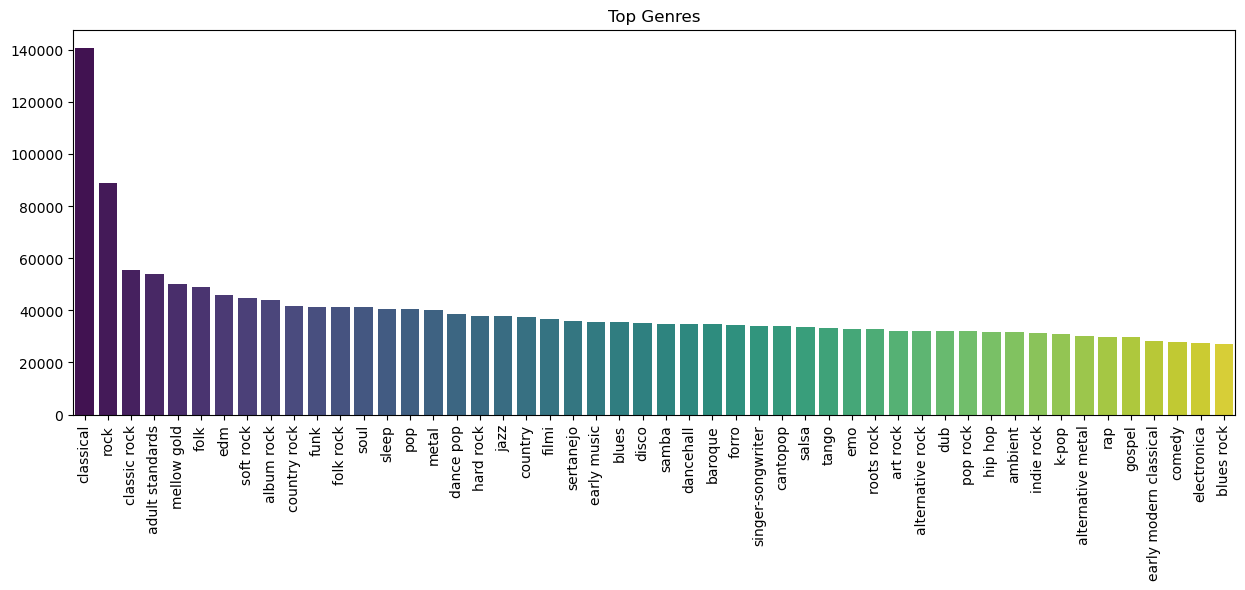

In [18]:
# Plot Top Genres
top_genres = [genre for genre, freq in genres.most_common(50)]
top_freq = [freq for genre, freq in genres.most_common(50)]

plt.figure(figsize=(15,5))
sns.barplot(x=top_genres, y=top_freq, palette='viridis')
plt.title("Top Genres")
plt.xticks(rotation=90)
plt.show()

In [19]:
def filter_top_genres(genre_list, top_genres):
    """
    Filters and expands a list of genres to include all possible combinations of sub-genres and returns only those
    genres that are in the top_genres list.

    Parameters:
    genre_list (list): A list of genre strings.

    Returns:
    list: A list of genres that are in the top 200 genres.
    """
    new_genre_list = []
    
    for genre in genre_list:
        new_genre_list = new_genre_list + genre.split(" ")
        
        # Create combinations of sub-genres
        for i in genre.split(" "):
            for j in genre.split(" "):
                if i != j:
                    new_genre_list.append(f'{i} {j}')

    # Filter out only those genres that are in the top_genres list
    return [genre for genre in new_genre_list if genre in top_genres]

In [20]:
df['new_genres'] = df['genres'].apply(filter_top_genres,top_genres=top_200_genres)
df[df['new_genres'].apply(lambda x:len(x) == 0)].shape

(234184, 21)

In [21]:
def most_frequent_word(list_, top=10):
    """
    Identifies the most frequent words in a list of strings.

    Parameters:
    list_ (list): A list of strings to analyze.
    top (int, optional): The number of top most frequent words to return. Default is 10.

    Returns:
    list: A list of tuples containing the most common words and their counts.
    """
    # Join all strings in the list into a single string
    string = ' '.join(list_)
    
    # Use regex to find all words, converting to lowercase
    words = re.findall(r'\w+', string.lower())
    
    # Count the frequency of each word
    word_counts = Counter(words)
    
    # Return the top most common words as specified by the 'top' parameter
    return word_counts.most_common(top)

Let us now look at the most frequent 100 words in the unassigned genres and pick which ones are worth adding.

In [22]:
unassigned_genres = list(set([g for genre in df[df['new_genres'].apply(lambda x:len(x) == 0)]['genres'] for g in genre]))
most_frequent_word(unassigned_genres,100)

[('indie', 351),
 ('musica', 71),
 ('electronic', 54),
 ('post', 53),
 ('traditional', 43),
 ('experimental', 40),
 ('deep', 28),
 ('rock', 27),
 ('music', 23),
 ('choir', 23),
 ('punk', 21),
 ('japanese', 21),
 ('band', 20),
 ('neo', 20),
 ('alternative', 19),
 ('j', 18),
 ('worship', 18),
 ('russian', 17),
 ('cumbia', 16),
 ('instrumental', 16),
 ('folklore', 15),
 ('new', 15),
 ('americana', 15),
 ('irish', 15),
 ('italian', 15),
 ('canadian', 14),
 ('drill', 14),
 ('bass', 14),
 ('classic', 14),
 ('disney', 13),
 ('dnb', 13),
 ('chinese', 12),
 ('modern', 12),
 ('american', 12),
 ('pop', 11),
 ('sound', 11),
 ('uk', 11),
 ('dutch', 11),
 ('s', 11),
 ('musique', 10),
 ('australian', 10),
 ('shoegaze', 10),
 ('progressive', 10),
 ('psych', 10),
 ('brasileiro', 9),
 ('brazilian', 9),
 ('polish', 9),
 ('doom', 9),
 ('indonesian', 9),
 ('orchestra', 9),
 ('vintage', 8),
 ('prog', 8),
 ('thrash', 8),
 ('hardcore', 8),
 ('children', 8),
 ('and', 8),
 ('british', 8),
 ('quebecois', 7),
 ('

In [23]:
additional_genres = ['shoegaze', 'hip hop', 'experimental','psychedelic', 'progressive', 'indie', 'electronic']
top_genres = top_200_genres + additional_genres
df['new_genres'] = df['genres'].apply(filter_top_genres, top_genres=top_genres)

In [24]:
df[df['new_genres'].apply(lambda x:len(x) == 0)].shape

(203203, 21)

In [25]:
df.drop(['genres','artist_name','artist_id','name'], axis=1, inplace=True)

In [26]:
# Craete a song Id dictionary for the recommender system
df.index = range(len(df))
songId_dict = df['id'].to_dict()

with open("../models/songId.pkl", 'wb') as file:
  pickle.dump(songId_dict, file)

In [27]:
df.drop('id',axis=1,inplace=True)

## Feature Scaling

In [28]:
columns_to_scale = df.columns[:-1]
columns_to_scale

Index(['popularity', 'duration_ms', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'year'],
      dtype='object')

In [29]:
df['year'] = df['year'].astype(int)

In [30]:
# Using StandarScaler to scale the numerical features
scaler = StandardScaler()
scaler.fit(df[columns_to_scale])
df[columns_to_scale] = scaler.transform(df[columns_to_scale])

In [31]:
df.describe()

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year
count,2506205.00000,2506205.00000,2506205.00000,2506205.00000,2506205.00000,2506205.00000,2506205.00000,2506205.00000,2506205.00000,2506205.00000,2506205.00000,2506205.00000,2506205.00000,2506205.00000,2506205.00000
mean,-0.00000,0.00000,-0.00000,-0.00000,0.00000,-0.00000,-0.00000,0.00000,-0.00000,0.00000,0.00000,-0.00000,-0.00000,0.00000,0.00000
std,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
min,-1.30596,-1.65738,-2.81171,-2.02120,-1.48133,-7.83674,-1.36038,-0.68478,-1.05373,-0.66113,-1.11262,-1.69983,-3.94874,-7.67507,-6.93415
25%,-0.86030,-0.46499,-0.69557,-0.78506,-0.91644,-0.39460,-1.36038,-0.41699,-0.99611,-0.66113,-0.61069,-0.85928,-0.77236,0.26839,-0.30708
50%,-0.11754,-0.15532,0.07053,0.13151,-0.06911,0.28120,0.73509,-0.33345,-0.31327,-0.65800,-0.43309,-0.04809,0.01704,0.26839,0.21783
75%,0.67474,0.24379,0.75626,0.87600,0.77822,0.69384,0.73509,-0.07984,1.02493,0.81338,0.31337,0.82183,0.61697,0.26839,0.67714
max,3.64580,38.87202,2.54561,1.49056,1.62556,2.59699,0.73509,6.55803,1.62807,2.13151,4.03534,1.97071,4.32183,2.25426,1.13644


In [32]:
with open("../models/scaler.pkl", 'wb') as file:
  pickle.dump(scaler, file)

## Encoding Genres

In [33]:
# Using MultilableBinarizer to encode the genres
mlb = MultiLabelBinarizer(sparse_output=True)
df = df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df.pop('new_genres')),
                index=df.index,
                columns=mlb.classes_))

In [34]:
with open("../models/mlb.pkl", 'wb') as file:
  pickle.dump(mlb, file)

In [36]:
print(f"There are {df.shape[1]} columns and {df.shape[0]} rows")

There are 209 columns and 2506205 rows


In [37]:
with open("../models/df.pkl", 'wb') as file:
  pickle.dump(df, file)